In [1]:
#Topic modelling notebook (LDA)

In [2]:
#import packages

import pandas as pd
import numpy as np
import re

#for web scraping
from bs4 import BeautifulSoup
import requests

#for tokenization
from nltk import sent_tokenize, word_tokenize
import spacy
from spacy.pipeline import Sentencizer
from spacy.lang.en import English

#for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# For visualization.
import plotly.express as px

#for bag of words model vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#to evaluate which document most aligns with a given vector/token
from sklearn.metrics.pairwise import cosine_similarity

#for LDA topic modelling
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
atla_df = pd.read_csv('/Users/justin/Documents/Personal/projects/atla_nlp/data/processed/atla_df.csv', keep_default_na=False, index_col=0)
#keep_default_na=False prevent empty strings from being read as NaN

In [4]:
atla_lines_df = pd.read_csv('/Users/justin/Documents/Personal/projects/atla_nlp/data/raw/atla_lines.csv', keep_default_na=False, index_col=0)
atla_lines_df

,episode_num,character_name,character_lines
0,1,Katara,[Narrating.] Water. Earth. Fire. Air. My grand...
1,1,Sokka,It's not getting away from me this time. [Clos...
2,1,Aang,[In a weak voice.] I need to ask you something...
3,1,Toph,
4,1,Zuko,Finally! [He turns around to face another pers...
...,...,...,...
361,61,Sokka,We're too late! The fleet's already taking off...
362,61,Aang,"Momo, time for you to go.Please listen to me. ..."
363,61,Toph,Too bad the Fire Lord's about to use it to des...
364,61,Zuko,It's not her I'm worried about. I'm worried ab...


In [5]:
atla_lines_df

,episode_num,character_name,character_lines
0,1,Katara,[Narrating.] Water. Earth. Fire. Air. My grand...
1,1,Sokka,It's not getting away from me this time. [Clos...
2,1,Aang,[In a weak voice.] I need to ask you something...
3,1,Toph,
4,1,Zuko,Finally! [He turns around to face another pers...
...,...,...,...
361,61,Sokka,We're too late! The fleet's already taking off...
362,61,Aang,"Momo, time for you to go.Please listen to me. ..."
363,61,Toph,Too bad the Fire Lord's about to use it to des...
364,61,Zuko,It's not her I'm worried about. I'm worried ab...


In [6]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def improved_filter(tokenized_doc):
  return [t.lemma_ for t in tokenized_doc if
          t.is_alpha and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.pos_ in ['NOUN', 'VERB', 'ADJ']]

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def improved_filter_1(tokenized_doc):
  return [t.text for t in tokenized_doc if
          t.is_alpha and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.pos_ in ['NOUN', 'VERB', 'ADJ']]

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
char_names_list = ['Aang', 'Sokka', 'Katara', 'Zuko', 'Iroh', 'Toph'] #to remove character names from tokenized text

def improved_filter_2(tokenized_doc):
  return [t.text for t in tokenized_doc if
          t.is_alpha and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and
          not t.text in char_names_list]

In [9]:
%%time
# tokenize everything and build the BOWs. 
# we're now using the POS tagger. The "w_pos" in the variable
# names below just means "with part-of-speech".
NUM_PROCESS = 4

tokenized_articles_w_pos = list(map(improved_filter, nlp.pipe(atla_lines_df.character_lines, n_process=NUM_PROCESS)))
# Build a Dictionary of word<-->id mappings.
dictionary_w_pos = corpora.Dictionary(tokenized_articles_w_pos)
#create a frequency bag-of-words from each article
corpus_bow_w_pos = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/justin/mambaforge/envs/nlp_env/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version 

CPU times: user 919 ms, sys: 134 ms, total: 1.05 s
Wall time: 15.5 s


In [10]:
len(tokenized_articles_w_pos[20])

276

In [11]:
#example of tokenized character dialogue
tokenized_articles_w_pos[20]

['know',
 'water',
 'marble',
 'close',
 'dive',
 'shirt',
 'emerge',
 'hand',
 'small',
 'gray',
 'marble',
 'check',
 'airbending',
 'stop',
 'perform',
 'trick',
 'frontal',
 'view',
 'duo',
 'background',
 'go',
 'need',
 'move',
 'reveal',
 'tired',
 'leg',
 'elbow',
 'say',
 'shore',
 'take',
 'sharp',
 'breath',
 'point',
 'start',
 'disrobe',
 'koi',
 'fish',
 'jump',
 'water',
 'background',
 'elephant',
 'koi',
 'go',
 'ride',
 'get',
 'watch',
 'close',
 'fish',
 'wave',
 'friend',
 'smile',
 'have',
 'fade',
 'face',
 'man',
 'flail',
 'arm',
 'leg',
 'know',
 'fault',
 'teenager',
 'look',
 'surprised',
 'word',
 'camera',
 'pan',
 'left',
 'reveal',
 'look',
 'sorry',
 'come',
 'want',
 'ride',
 'elephant',
 'brighten',
 'expression',
 'face',
 'island',
 'name',
 'know',
 'look',
 'pensive',
 'statue',
 'look',
 'ground',
 'speak',
 'soft',
 'calm',
 'voice',
 'camera',
 'zoom',
 'know',
 'friend',
 'point',
 'view',
 'smile',
 'frontal',
 'view',
 'look',
 'face',
 'rel

In [12]:
#view example of word<-->id mappings

sample_token = 'eclipse'
print(f'Id for \'{sample_token}\' token: {dictionary_w_pos.token2id[sample_token]}')

Id for 'eclipse' token: 2666


In [13]:
#bow representation of example character dialogue
corpus_bow_w_pos[20]

[(1, 1),
 (10, 4),
 (26, 1),
 (29, 3),
 (37, 2),
 (39, 4),
 (65, 1),
 (66, 3),
 (68, 4),
 (73, 2),
 (76, 2),
 (81, 4),
 (87, 5),
 (90, 1),
 (103, 10),
 (105, 1),
 (106, 2),
 (107, 1),
 (110, 1),
 (112, 9),
 (117, 1),
 (118, 1),
 (128, 1),
 (130, 3),
 (138, 2),
 (142, 2),
 (143, 1),
 (148, 1),
 (153, 2),
 (154, 5),
 (160, 1),
 (161, 3),
 (172, 1),
 (175, 1),
 (177, 4),
 (180, 1),
 (185, 2),
 (187, 2),
 (188, 1),
 (189, 1),
 (196, 1),
 (202, 1),
 (207, 2),
 (212, 4),
 (215, 1),
 (219, 1),
 (235, 2),
 (249, 1),
 (257, 1),
 (260, 4),
 (262, 6),
 (264, 1),
 (265, 1),
 (279, 1),
 (287, 1),
 (294, 1),
 (299, 1),
 (317, 1),
 (318, 2),
 (323, 1),
 (325, 1),
 (340, 1),
 (341, 1),
 (361, 1),
 (367, 2),
 (371, 1),
 (374, 1),
 (380, 1),
 (387, 1),
 (388, 2),
 (393, 1),
 (395, 1),
 (414, 1),
 (418, 3),
 (419, 1),
 (453, 2),
 (463, 1),
 (465, 1),
 (467, 1),
 (481, 1),
 (507, 4),
 (517, 1),
 (526, 1),
 (537, 1),
 (548, 1),
 (549, 1),
 (552, 2),
 (561, 1),
 (562, 1),
 (565, 1),
 (566, 2),
 (567, 2),
 (

In [14]:
%%time
#train the LDA model
NUM_TOPICS = 20

lda_model = models.LdaModel(corpus=corpus_bow_w_pos, num_topics=NUM_TOPICS, id2word=dictionary_w_pos, random_state=1)

CPU times: user 213 ms, sys: 2.4 ms, total: 216 ms
Wall time: 217 ms


In [15]:
lda_model.print_topics()

[(0,
  '0.016*"know" + 0.014*"think" + 0.013*"look" + 0.013*"go" + 0.011*"hand" + 0.009*"point" + 0.008*"get" + 0.006*"need" + 0.006*"right" + 0.006*"face"'),
 (1,
  '0.016*"know" + 0.013*"look" + 0.012*"think" + 0.012*"get" + 0.010*"need" + 0.009*"go" + 0.009*"find" + 0.008*"time" + 0.008*"hand" + 0.008*"little"'),
 (2,
  '0.018*"think" + 0.017*"go" + 0.016*"know" + 0.016*"look" + 0.011*"turn" + 0.009*"need" + 0.009*"people" + 0.008*"come" + 0.008*"help" + 0.008*"want"'),
 (3,
  '0.023*"look" + 0.020*"go" + 0.019*"know" + 0.011*"need" + 0.010*"get" + 0.010*"find" + 0.009*"turn" + 0.009*"face" + 0.008*"think" + 0.008*"come"'),
 (4,
  '0.021*"know" + 0.015*"look" + 0.013*"go" + 0.013*"think" + 0.012*"hand" + 0.011*"come" + 0.009*"want" + 0.008*"good" + 0.007*"tell" + 0.007*"need"'),
 (5,
  '0.017*"get" + 0.016*"think" + 0.014*"know" + 0.011*"look" + 0.010*"let" + 0.009*"come" + 0.009*"go" + 0.008*"take" + 0.007*"guy" + 0.006*"help"'),
 (6,
  '0.017*"get" + 0.012*"look" + 0.008*"want" + 

In [16]:
# The size of the dictionary before filtering.
len(dictionary_w_pos)

3675

In [17]:
#The lower bound is an *absolute* number, and the upper bound is a *percentage*. 
#Here, we're saying filter out words which occur in fewer than N documents and more than M% of the documents.
dictionary_w_pos.filter_extremes(no_below=5, no_above=0.5)

In [18]:
# The size of the dictionary after filtering.
len(dictionary_w_pos)

972

In [19]:
# Rebuild bag of words.
corpus_bow_w_pos_filtered = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

In [20]:
%%time

#*alpha* is the prior on the document-topic distribution
# *eta* is the prior on the topic-word distribution (this was *beta* in the slides)
# *passes* is the number of complete passes through the corpus during training

lda_model = models.ldamodel.LdaModel(corpus=corpus_bow_w_pos_filtered,
                                     id2word=dictionary_w_pos,
                                     num_topics=NUM_TOPICS,
                                     passes=100,
                                     alpha='auto',
                                     eta='auto',
                                     random_state=1)

CPU times: user 11.5 s, sys: 31.5 ms, total: 11.5 s
Wall time: 11.5 s


In [21]:
lda_model.print_topics()

[(0,
  '0.046*"pirate" + 0.029*"water" + 0.025*"get" + 0.023*"scroll" + 0.021*"run" + 0.017*"boat" + 0.016*"try" + 0.016*"waterbending" + 0.015*"hand" + 0.012*"air"'),
 (1,
  '0.027*"need" + 0.021*"save" + 0.021*"tone" + 0.017*"brother" + 0.017*"care" + 0.014*"help" + 0.014*"tell" + 0.012*"water" + 0.012*"let" + 0.012*"hand"'),
 (2,
  '0.052*"tea" + 0.022*"shop" + 0.018*"come" + 0.018*"new" + 0.017*"think" + 0.017*"want" + 0.015*"cup" + 0.013*"shot" + 0.013*"love" + 0.012*"need"'),
 (3,
  '0.022*"ground" + 0.018*"hand" + 0.018*"get" + 0.017*"head" + 0.016*"let" + 0.015*"rock" + 0.015*"stop" + 0.013*"library" + 0.012*"bag" + 0.011*"eye"'),
 (4,
  '0.092*"view" + 0.030*"close" + 0.021*"think" + 0.020*"frontal" + 0.018*"camera" + 0.015*"cut" + 0.014*"walk" + 0.012*"shoulder" + 0.010*"hand" + 0.010*"right"'),
 (5,
  '0.021*"think" + 0.021*"get" + 0.011*"turn" + 0.011*"guy" + 0.010*"walk" + 0.009*"arm" + 0.009*"come" + 0.009*"need" + 0.008*"point" + 0.008*"head"'),
 (6,
  '0.019*"cut" + 0.0

In [22]:
#We set the training algorithm to learn priors for *alpha* and *eta*. lets ee them
#values close to zero means most articles being dominated by one or just a few topics, and most topics being dominated by a handful of words.

print(lda_model.alpha)
print(lda_model.eta)

[0.01632774 0.01222993 0.01971982 0.02055126 0.03488256 0.06583382
 0.047633   0.01141908 0.01333187 0.01543322 0.01513042 0.01441099
 0.01812884 0.01592237 0.02636009 0.016969   0.01083905 0.01265681
 0.03039841 0.04698285]
[0.05461142 0.0866128  0.07113944 0.04950268 0.04929354 0.05118438
 0.05839609 0.05198365 0.0583877  0.09277208 0.23757467 0.0517217
 0.07790997 0.04927009 0.0865938  0.06167402 0.13038628 0.09558173
 0.05179023 0.05840432 0.04972326 0.07674622 0.05471691 0.07741959
 0.07805627 0.06205208 0.08699813 0.05207312 0.09987133 0.09319001
 0.05171163 0.06180198 0.06639548 0.17425004 0.06158929 0.5920243
 0.07209183 0.07735957 0.05215245 0.05884458 0.28962213 0.05492149
 0.11641151 0.06602882 0.05514129 0.10488828 0.07157733 0.06181588
 0.05784294 0.09043322 0.0547522  0.05564599 0.1412888  0.05170536
 0.35422742 0.0777928  0.08649184 0.05754252 0.28082228 0.07230113
 0.12222542 0.07136969 0.06186961 0.06716248 0.05475326 0.05486032
 0.08585114 0.2644332  0.05281493 0.1330

In [23]:
#We can look at the topic distribution comprising a given article using the model's *get_document_topics* method
article_idx = 0
print(atla_lines_df.character_lines[article_idx][:300])
print(atla_lines_df.character_name[article_idx])

[Narrating.] Water. Earth. Fire. Air. My grandmother used to tell me stories about the old days: a time of peace when the Avatar kept balance between the Water Tribes, Earth Kingdom, Fire Nation and Air Nomads. But that all changed when the Fire Nation attacked. Only the Avatar mastered all four ele
Katara


In [24]:
# Return topic distribution for an article sorted by probability.
topics = sorted(lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx]), key=lambda tup: tup[1])[::-1]
print(atla_lines_df.character_name[article_idx])
print(topics)

Katara
[(19, 0.57265186), (6, 0.28937593), (11, 0.1366254)]


In [25]:
# View the words of the top topic from the referenced article.
lda_model.show_topic(topics[0][0])

[('need', 0.020904869),
 ('help', 0.015579987),
 ('find', 0.015431736),
 ('hand', 0.014853701),
 ('think', 0.014326396),
 ('good', 0.012502412),
 ('get', 0.01106566),
 ('want', 0.010475842),
 ('girl', 0.009609433),
 ('leave', 0.008940554)]

In [26]:
# View the words of the second-most prevalent topic from the previous article.
lda_model.show_topic(topics[1][0])

[('cut', 0.019284844),
 ('want', 0.01671844),
 ('think', 0.016130233),
 ('come', 0.012782591),
 ('find', 0.012752028),
 ('way', 0.012461005),
 ('let', 0.012369536),
 ('hand', 0.010771684),
 ('shot', 0.0105163725),
 ('face', 0.01026528)]

In [27]:
def get_top_topics(article_idx, min_topic_prob):

#The function below takes a document index and returns a **DataFrame** containing:
#1. the topics comprising the document up to a minimum probability.
#2. the top words of each topic.

  # Sort from highest to lowest topic probability.
  topic_prob_pairs = sorted(lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx],
                                                          minimum_probability=min_topic_prob),
                            key=lambda tup: tup[1])[::-1]

  word_prob_pairs = [lda_model.show_topic(pair[0]) for pair in topic_prob_pairs]
  topic_words = [[pair[0] for pair in collection] for collection in word_prob_pairs]

  data = {
      'Major Topics': topic_prob_pairs,
      'Topic Words': topic_words
  }

  return pd.DataFrame(data)


In [28]:
pd.set_option('max_colwidth', 600)
snippet_length = 300
min_topic_prob = 0.25

article_idx = 1
print(atla_lines_df.character_name[article_idx])
print(atla_lines_df.character_lines[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)

Sokka
It's not getting away from me this time. [Close-up of Sokka as he grins confidently over his shoulder in the direction of Katara.] Watch and learn, Katara. This is how you catch a fish.[Close-up of Sokka; whispering.] Sshh! Katara, you're going to scare it away. [A look of bliss adorns his face. He 


,Major Topics,Topic Words
0,"(5, 0.92670405)","[think, get, turn, guy, walk, arm, come, need, point, head]"


In [29]:
article_idx = 10
print(atla_lines_df.character_name[article_idx])
print(atla_lines_df.character_lines[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)

Zuko
[Angrily.] Where are you hiding him?[Shaking Kanna; annoyed.] He'd be about this age, master of all elements?[Angrily.] I know you're hiding him![Shocked.] You're the airbender? You're the Avatar?I've spent years preparing for this encounter. Training, meditating. [Angrily.] You're just a child![Boa


,Major Topics,Topic Words
0,"(16, 0.98978233)","[staff, cut, ship, shot, father, soldier, hand, hide, snow, head]"


In [30]:
%%time
#coherence - measure how semantically coherent a topic is to calculate co-occurrence among the words. 
# That is, how often the top words in a topic co-occur together among the documents versus how often they occur independently.
#larger magnitude means more coherence

coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles_w_pos, dictionary=dictionary_w_pos, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -1.4708280363378676
CPU times: user 25.4 ms, sys: 963 µs, total: 26.4 ms
Wall time: 25.9 ms


In [31]:
def render_word_cloud(model, rows, cols, max_words):
  word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
  fig, axes = plt.subplots(rows, cols, figsize=(15,15))

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(model.show_topic(i))
      word_cloud.generate_from_frequencies(topic_words)
      plt.gca().imshow(word_cloud, interpolation='bilinear')
      plt.gca().set_title('Topic {id}'.format(id=i))
      plt.gca().axis('off')

  plt.axis('off')
  plt.show()

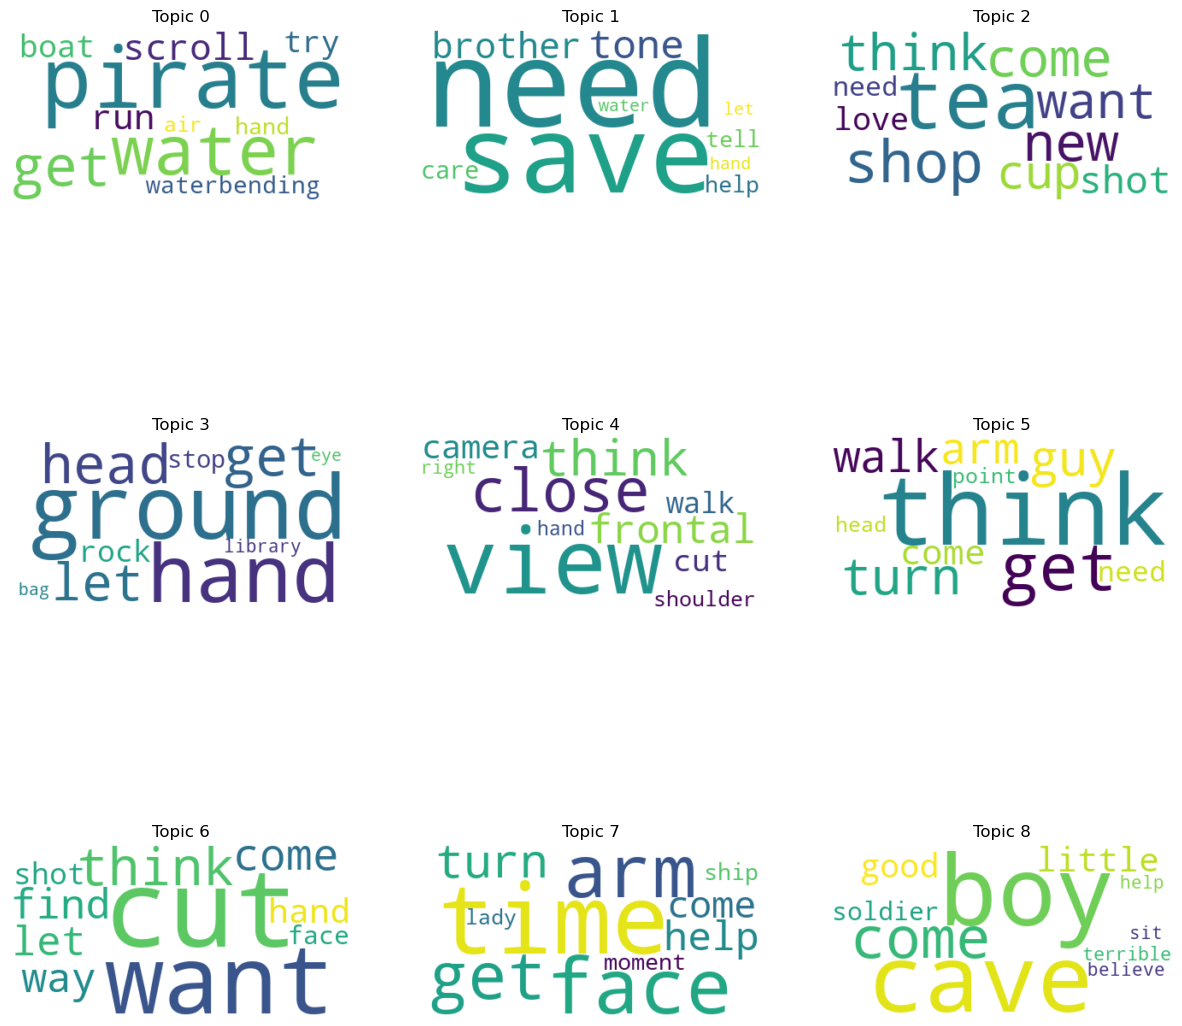

In [32]:
# Here we'll visualize the first nine topics.
render_word_cloud(lda_model, 3, 3, 10)

In [33]:
#finding similar documents
#using **MatrixSimilarity** which computes cosine similarity across a corpus and stores them in an index.<br>
lda_index = similarities.MatrixSimilarity(lda_model[corpus_bow_w_pos_filtered], num_features=len(dictionary_w_pos))

In [34]:
def get_similar_articles(index, model, article_bow, top_n=5, first_m_words=300):
  #Utility function to help retrieve the *first_m_words* of the *top_n* most similar documents

  # model[article_bow] retrieves the topic distribution for the BOW.
  # index[model[article_bow] compares the topic distribution for the BOW against the similarity index previously computed.
  similar_docs = index[model[article_bow]]
  top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[1:top_n+1]

  # Return a list of tuples with each tuple: (article id, similarity score, article speaker, first_m_words of article)
  return list(map(lambda entry: (entry[0], entry[1], atla_lines_df.character_name[entry[0]], atla_lines_df.character_lines[entry[0]][:first_m_words]), top_n_docs))

In [35]:
article_idx = 0
print(atla_lines_df.character_name[article_idx])
print(atla_lines_df.character_lines[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])

Katara
[Narrating.] Water. Earth. Fire. Air. My grandmother used to tell me stories about the old days: a time of peace when the Avatar kept balance between the Water Tribes, Earth Kingdom, Fire Nation and Air Nomads. But that all changed when the Fire Nation attacked. Only the Avatar mastered all four ele 



[(246,
  0.97350013,
  'Katara',
  "Aang, you're awake! [The two race over to him.][Hugs Aang.] You're not dreaming. You're finally awake.You need to take it easy, okay? You got hurt pretty bad. [Smiling at him.] I like your hair.A few weeks.[Looking away, annoyed. Annoyed tone.] We're fine, Dad.[Placing her hands on Aang's shoulders "),
 (278,
  0.9703084,
  'Aang',
  "[Talking in his sleep.] Okay, Roku.There it is. That's Roku's home.[He climbs on Fang, who flies off.] Where're we going?[Surprised.] You were friends with Fire Lord Sozin\u200c?You don't have to tell me.Wait, whose party is it?[Excited.] Hey, we're almost at the Southern Air Temple!No way!He's air surfi"),
 (295,
  0.8925173,
  'Sokka',
  "[Somewhat excitedly.] This is it! The official rendezvous point for the invasion force.Before we split up, my dad and I found this island on the map. It's uninhabited, and the harbors surrounded by the cliffs seemed like the perfect secluded place.[Yawns.] Whatever. That's like four 

In [36]:
article_idx = 103
print(atla_lines_df.character_name[article_idx])
print(atla_lines_df.character_lines[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])

Sokka
[Hanging lazily over the back of Appa's saddle; grumpily.] I'm not one to complain, [Side-view shows Appa flying just above the water.] but can't Appa fly any higher?[Back-view of Sokka looking over his shoulder; sarcastically.] I'd love to. [Points to his back.] Climb on everyone, [Shakes his rear. 



[(134,
  0.99481595,
  'Aang',
  "[Viewing the city, his back to the camera; in a somewhat shocked tone.] I can't believe it. I know the War has spread far, [Turning toward the camera sadly.] but Omashu always seemed ... untouchable.No, I'm going in to find Bumi.[Angrily.] What? If he's still what?This isn't about finding a teacher."),
 (307,
  0.9881761,
  'Sokka',
  "[Brightening.] Dad! [Rising and approaching the two.] You're on your feet again.Everything's going smoothly and the eclipse hasn't even kicked in yet.[Shocked.] What? [Cuts to shot of Aang riding in on his glider, dodging several fireballs. He lands in front of the group.] Please tell me you're here"),
 (18,
  0.952863,
  'Katara',
  "[Nonchalantly, still focusing on her task at hand.] That's great, Aang.[Looks over Aang and attempts to show enthusiasm.] That's great![Close side-view shot of Katara as she casts her brother an annoyed glare; irritably.] What does me being a girl have to do with sewing?[Suddenly smiles. Sa

In [37]:
#query for documents similar to new, unseen documents

test_article = "I am the Avatar, it's up to me to stop this"

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(46,
  0.9935159,
  'Zuko',
  "[The Senlin Village leader gasps.] Having trouble sleeping? [Pushes the man back through the door, knocking him down. Frontal shot as he approaches him.] Seen the Avatar lately?I have no choice, Uncle.[Breaks away from telescope to talk to his uncle.] I'm chasing the Avatar! My father will understan"),
 (110,
  0.9935159,
  'Aang',
  "[Stops bending at the sound of his name; Momo lands on his head.] Yes, Master Pakku?[Jumps off the ground with airbending.] I wouldn't say mastered, but check this out.I wasn't there when the Fire Nation attacked my people. [Determined.] I'm going to make a difference this time.Yip-yip!I'll take it "),
 (121,
  0.9935159,
  'Sokka',
  "[Rises to view their destination.] There it is![Viewing the display.] Not bad, not bad.But sir, the thing is, Aang can only do those things when he's in the Avatar State.[Resting on his bed with his arms behind his head.] Why not? Remember when he took out the Fire Navy? [Widens his eyes.] He